In [29]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

# Read the Parquet file
df = spark.read.parquet("working_data/Filtered_Fish_Data.parquet")

In [30]:
df.show(5)
df.printSchema()
df.select("SURVEY_ID").count()

+---------+---------------+----------+------------+--------------------+-----------------+----------------------+---------------------+-----------+--------+
|SURVEY_ID|EVENT_DATE_YEAR|SPECIES_ID|SPECIES_NAME|          LATIN_NAME|SURVEY_RANKED_NGR|SURVEY_RANKED_NORTHING|SURVEY_RANKED_EASTING|FISH_LENGTH|AGE_BAND|
+---------+---------------+----------+------------+--------------------+-----------------+----------------------+---------------------+-----------+--------+
|   111032|           1989|       196|        Rudd|Scardinius erythr...|     SE5530009200|                409200|               455300|        142|     >4+|
|    72230|           2002|       196|        Rudd|Scardinius erythr...|     SE7920071500|                471500|               479200|         29|      0+|
|    51949|           2001|       196|        Rudd|Scardinius erythr...|     SU5880008700|                108700|               458800|        157|      0+|
|    67760|           2001|       196|        Rudd|Scardin

4915478

In [32]:
from pyspark.sql.functions import col

df = df.filter(
    (col("AGE_BAND").isNotNull()) &
    (~col("AGE_BAND").contains(">")) &
    (~col("AGE_BAND").contains("<")) &
    (col("AGE_BAND") != "0")
)
df.show(5)
df.select("SURVEY_ID").count()

+---------+---------------+----------+------------+--------------------+-----------------+----------------------+---------------------+-----------+--------+
|SURVEY_ID|EVENT_DATE_YEAR|SPECIES_ID|SPECIES_NAME|          LATIN_NAME|SURVEY_RANKED_NGR|SURVEY_RANKED_NORTHING|SURVEY_RANKED_EASTING|FISH_LENGTH|AGE_BAND|
+---------+---------------+----------+------------+--------------------+-----------------+----------------------+---------------------+-----------+--------+
|    72230|           2002|       196|        Rudd|Scardinius erythr...|     SE7920071500|                471500|               479200|         29|      0+|
|    51949|           2001|       196|        Rudd|Scardinius erythr...|     SU5880008700|                108700|               458800|        157|      0+|
|    67760|           2001|       196|        Rudd|Scardinius erythr...|     TA0910054200|                454200|               509100|         30|      0+|
|   150298|           2017|       196|        Rudd|Scardin

162494

In [33]:
df = df.filter(
    (col("EVENT_DATE_YEAR") >= 2005)
)
df.show(5)
df.select("SURVEY_ID").count()

+---------+---------------+----------+------------+--------------------+-----------------+----------------------+---------------------+-----------+--------+
|SURVEY_ID|EVENT_DATE_YEAR|SPECIES_ID|SPECIES_NAME|          LATIN_NAME|SURVEY_RANKED_NGR|SURVEY_RANKED_NORTHING|SURVEY_RANKED_EASTING|FISH_LENGTH|AGE_BAND|
+---------+---------------+----------+------------+--------------------+-----------------+----------------------+---------------------+-----------+--------+
|   150298|           2017|       196|        Rudd|Scardinius erythr...|     TG4050021700|                321700|               640500|        143|       3|
|   150298|           2017|       196|        Rudd|Scardinius erythr...|     TG4050021700|                321700|               640500|        118|       3|
|   150298|           2017|       196|        Rudd|Scardinius erythr...|     TG4050021700|                321700|               640500|        136|       3|
|   150298|           2017|       196|        Rudd|Scardin

99186

In [34]:
from pyspark.sql.functions import regexp_replace

df = df.withColumn("AGE_BAND", regexp_replace("AGE_BAND", r"\+", ""))
df.select("AGE_BAND").show(10)
df.select("SURVEY_ID").count()

+--------+
|AGE_BAND|
+--------+
|       3|
|       3|
|       3|
|       3|
|       3|
|       3|
|       3|
|       3|
|       3|
|       3|
+--------+
only showing top 10 rows


99186

In [35]:
from pyspark.sql.functions import when
from pyspark.sql.functions import first

df = df.withColumn(
    "SPECIES_ID",
    when(col("SPECIES_ID") == 212, 213).otherwise(col("SPECIES_ID"))
).withColumn(
    "SPECIES_NAME",
    when(col("SPECIES_NAME") == "Pike varieties", "Pike").otherwise(col("SPECIES_NAME"))
)

species_counts_post = df.groupBy("SPECIES_ID", "SPECIES_NAME", "LATIN_NAME") \
    .count() \
    .orderBy("SPECIES_ID", "SPECIES_NAME", "LATIN_NAME")
species_counts_post.show()

+----------+------------+--------------------+-----+
|SPECIES_ID|SPECIES_NAME|          LATIN_NAME|count|
+----------+------------+--------------------+-----+
|       151|      Barbel|       Barbus barbus| 1400|
|       152|        Chub|  Leuciscus cephalus|22327|
|       153|        Dace| Leuciscus leuciscus|19875|
|       154|    Grayling| Thymallus thymallus| 2306|
|       181|       Bleak|   Alburnus alburnus|  883|
|       182|Common bream|       Abramis brama| 3577|
|       193|     Gudgeon|         Gobio gobio| 1519|
|       194|       Roach|     Rutilus rutilus|42635|
|       196|        Rudd|Scardinius erythr...|  613|
|       199|Silver bream|    Abramis bjoerkna|  474|
|       211|       Perch|   Perca fluviatilis| 1948|
|       213|        Pike|         Esox lucius| 1629|
+----------+------------+--------------------+-----+



In [36]:
# Read the FW_Fish_Counts.csv file into a Spark DataFrame
fw_fish_counts = spark.read.option("header", True).csv("raw_data/FW_Fish_Counts.csv")

# Ensure SURVEY_ID columns are of the same type for join
fw_fish_counts = fw_fish_counts.withColumn("SURVEY_ID", col("SURVEY_ID").cast("int"))

# Join df with fw_fish_counts on SURVEY_ID to add the REGION column
df_with_region = df.join(fw_fish_counts.select("SURVEY_ID", "REGION"), on="SURVEY_ID", how="left")

df_with_region.show(5)

+---------+---------------+----------+------------+--------------------+-----------------+----------------------+---------------------+-----------+--------+-------+
|SURVEY_ID|EVENT_DATE_YEAR|SPECIES_ID|SPECIES_NAME|          LATIN_NAME|SURVEY_RANKED_NGR|SURVEY_RANKED_NORTHING|SURVEY_RANKED_EASTING|FISH_LENGTH|AGE_BAND| REGION|
+---------+---------------+----------+------------+--------------------+-----------------+----------------------+---------------------+-----------+--------+-------+
|   150298|           2017|       196|        Rudd|Scardinius erythr...|     TG4050021700|                321700|               640500|        143|       3|Anglian|
|   150298|           2017|       196|        Rudd|Scardinius erythr...|     TG4050021700|                321700|               640500|        143|       3|Anglian|
|   150298|           2017|       196|        Rudd|Scardinius erythr...|     TG4050021700|                321700|               640500|        143|       3|Anglian|
|   150298

In [37]:
from pyspark.sql.functions import expr

# List of quantiles to compute
quantiles = [0.1, 0.4, 0.5, 0.6, 0.9]

# For each species and age, compute the quantiles of FISH_LENGTH
growth_curves = (
    df.groupBy("SPECIES_NAME", "AGE_BAND")
      .agg(
          expr("percentile_approx(FISH_LENGTH, 0.1) as very_slow"),
          expr("percentile_approx(FISH_LENGTH, 0.4) as slow"),
          expr("percentile_approx(FISH_LENGTH, 0.5) as average"),
          expr("percentile_approx(FISH_LENGTH, 0.6) as fast"),
          expr("percentile_approx(FISH_LENGTH, 0.9) as very_fast"),
          expr("count(FISH_LENGTH) as n")
      )
      .orderBy("SPECIES_NAME", expr("cast(AGE_BAND as int)"))
)

growth_curves.show(100, truncate=False)

+------------+--------+---------+----+-------+----+---------+----+
|SPECIES_NAME|AGE_BAND|very_slow|slow|average|fast|very_fast|n   |
+------------+--------+---------+----+-------+----+---------+----+
|Barbel      |0       |30       |36  |38     |44  |105      |18  |
|Barbel      |1       |71       |96  |102    |107 |126      |150 |
|Barbel      |2       |110      |142 |156    |165 |211      |237 |
|Barbel      |3       |163      |193 |213    |222 |262      |177 |
|Barbel      |4       |210      |247 |268    |276 |350      |78  |
|Barbel      |5       |252      |310 |329    |350 |404      |78  |
|Barbel      |6       |325      |390 |415    |450 |505      |62  |
|Barbel      |7       |372      |452 |477    |493 |580      |79  |
|Barbel      |8       |387      |452 |472    |496 |568      |74  |
|Barbel      |9       |444      |495 |510    |527 |582      |87  |
|Barbel      |10      |448      |505 |523    |544 |605      |84  |
|Barbel      |11      |460      |534 |549    |570 |642      |6

In [38]:
growth_curves.coalesce(1).write.mode("overwrite").option("header", True).csv("outputs/growth_curves.csv")

In [39]:
from pyspark.sql.functions import expr, when, col

# Define the centre of England (British National Grid)
centre_northing = 350000

# Add a region column: 'North' if northing >= centre, else 'South'
df_split = df.withColumn(
    "region_ns",
    when(col("SURVEY_RANKED_NORTHING") >= centre_northing, "North").otherwise("South")
)

# For each species, age, and region, compute the quantiles of FISH_LENGTH
growth_curves_split = (
    df_split.groupBy("SPECIES_NAME", "AGE_BAND", "region_ns")
      .agg(
          expr("percentile_approx(FISH_LENGTH, 0.1) as very_slow"),
          expr("percentile_approx(FISH_LENGTH, 0.4) as slow"),
          expr("percentile_approx(FISH_LENGTH, 0.5) as average"),
          expr("percentile_approx(FISH_LENGTH, 0.6) as fast"),
          expr("percentile_approx(FISH_LENGTH, 0.9) as very_fast"),
          expr("count(FISH_LENGTH) as n")
      )
      .orderBy("SPECIES_NAME", expr("cast(AGE_BAND as int)"), "region_ns")
)

growth_curves_split.show(100, truncate=False)

+------------+--------+---------+---------+----+-------+----+---------+----+
|SPECIES_NAME|AGE_BAND|region_ns|very_slow|slow|average|fast|very_fast|n   |
+------------+--------+---------+---------+----+-------+----+---------+----+
|Barbel      |0       |North    |66       |66  |66     |66  |66       |1   |
|Barbel      |0       |South    |30       |36  |38     |44  |105      |17  |
|Barbel      |1       |North    |62       |82  |91     |94  |112      |41  |
|Barbel      |1       |South    |82       |102 |105    |110 |132      |109 |
|Barbel      |2       |North    |113      |129 |132    |137 |195      |70  |
|Barbel      |2       |South    |108      |156 |165    |175 |215      |167 |
|Barbel      |3       |North    |159      |177 |181    |190 |241      |62  |
|Barbel      |3       |South    |165      |215 |223    |229 |272      |115 |
|Barbel      |4       |North    |214      |247 |263    |272 |360      |28  |
|Barbel      |4       |South    |209      |246 |268    |278 |340      |50  |

In [40]:
growth_curves_region.coalesce(1).write.mode("overwrite").option("header", True).csv("outputs/growth_curves_region.csv")

In [41]:
from pyspark.sql.functions import sum as spark_sum

# Aggregate counts for each species by summing 'n' for North and South
species_region_counts = (
    growth_curves_region.groupBy("SPECIES_NAME")
    .agg(
        spark_sum(
            when(col("region_ns") == "North", col("n")).otherwise(0)
        ).alias("north_count"),
        spark_sum(
            when(col("region_ns") == "South", col("n")).otherwise(0)
        ).alias("south_count"),
        spark_sum("n").alias("total_count")
    )
)

species_region_counts.show(truncate=False)

+------------+-----------+-----------+-----------+
|SPECIES_NAME|north_count|south_count|total_count|
+------------+-----------+-----------+-----------+
|Roach       |5692       |36948      |42640      |
|Chub        |3918       |18415      |22333      |
|Bleak       |549        |335        |884        |
|Rudd        |11         |602        |613        |
|Barbel      |491        |910        |1401       |
|Dace        |2871       |17012      |19883      |
|Common bream|277        |3302       |3579       |
|Pike        |784        |846        |1630       |
|Gudgeon     |1351       |168        |1519       |
|Perch       |1245       |703        |1948       |
|Grayling    |1775       |562        |2337       |
|Silver bream|22         |452        |474        |
+------------+-----------+-----------+-----------+



In [42]:
import pandas as pd

# Collect the growth_curves DataFrame to a Pandas DataFrame
growth_curves_pd = growth_curves.toPandas()

# Create a Pandas Excel writer using XlsxWriter as the engine
with pd.ExcelWriter("outputs/growth_curves_by_species.xlsx", engine="xlsxwriter") as writer:
    for species, group in growth_curves_pd.groupby("SPECIES_NAME"):
        group.to_excel(writer, sheet_name=species[:31], index=False)

In [43]:
# Collect the growth_curves_region DataFrame to a Pandas DataFrame
growth_curves_region_pd = growth_curves_region.toPandas()

# Sort by region_ns ('North' first, then 'South'), then by AGE_BAND (as integer)
growth_curves_region_pd['AGE_BAND'] = growth_curves_region_pd['AGE_BAND'].astype(int)
growth_curves_region_pd['region_ns'] = pd.Categorical(
    growth_curves_region_pd['region_ns'], categories=['North', 'South'], ordered=True
)
growth_curves_region_pd = growth_curves_region_pd.sort_values(
    ['SPECIES_NAME', 'region_ns', 'AGE_BAND']
)

# Write to Excel, one sheet per species
with pd.ExcelWriter("outputs/growth_curves_by_species_region.xlsx", engine="xlsxwriter") as writer:
    for species, group in growth_curves_region_pd.groupby("SPECIES_NAME"):
        group.to_excel(writer, sheet_name=species[:31], index=False)

In [44]:
from pyspark.sql.functions import expr, when, col

# Map REGION to new region groups
df_3region = df_with_region.withColumn(
    "region_group",
    when(col("REGION").isin("Yorkshire and North East", "North West"), "North")
    .when(col("REGION").isin("Anglian", "Midlands"), "AngMid")
    .when(col("REGION").isin("South West", "South East"), "South")
    .otherwise("Other")
)

# Check for any "Other" values and raise a warning if present
other_count = df_3region.filter(col("region_group") == "Other").count()
if other_count > 0:
    print(f"WARNING: {other_count} records found with region_group='Other'. Please check REGION values.")

# For each species, age, and region_group, compute the quantiles of FISH_LENGTH
growth_curves_3region = (
    df_3region.groupBy("SPECIES_NAME", "AGE_BAND", "region_group")
      .agg(
          expr("percentile_approx(FISH_LENGTH, 0.1) as very_slow"),
          expr("percentile_approx(FISH_LENGTH, 0.4) as slow"),
          expr("percentile_approx(FISH_LENGTH, 0.5) as average"),
          expr("percentile_approx(FISH_LENGTH, 0.6) as fast"),
          expr("percentile_approx(FISH_LENGTH, 0.9) as very_fast"),
          expr("count(FISH_LENGTH) as n")
      )
      .orderBy("SPECIES_NAME", expr("cast(AGE_BAND as int)"), "region_group")
)

growth_curves_3region.show(100, truncate=False)

+------------+--------+------------+---------+----+-------+----+---------+-----+
|SPECIES_NAME|AGE_BAND|region_group|very_slow|slow|average|fast|very_fast|n    |
+------------+--------+------------+---------+----+-------+----+---------+-----+
|Barbel      |0       |AngMid      |30       |36  |36     |36  |44       |117  |
|Barbel      |0       |North       |66       |66  |66     |66  |66       |10   |
|Barbel      |0       |South       |70       |95  |105    |105 |115      |43   |
|Barbel      |1       |AngMid      |83       |99  |103    |108 |170      |244  |
|Barbel      |1       |North       |62       |82  |93     |95  |113      |466  |
|Barbel      |1       |South       |82       |102 |107    |110 |126      |943  |
|Barbel      |2       |AngMid      |131      |165 |183    |192 |217      |451  |
|Barbel      |2       |North       |114      |129 |133    |138 |181      |817  |
|Barbel      |2       |South       |108      |153 |160    |168 |199      |1155 |
|Barbel      |3       |AngMi

In [45]:
import pandas as pd

# Collect the growth_curves_region DataFrame to a Pandas DataFrame
growth_curves_3region_pd = growth_curves_3region.toPandas()

# Create a Pandas Excel writer using XlsxWriter as the engine
with pd.ExcelWriter("outputs/growth_curves_3region_by_species.xlsx", engine="xlsxwriter") as writer:
    # Write the full DataFrame to a sheet
    growth_curves_3region_pd.to_excel(writer, sheet_name="All_Data", index=False)
    # Write one sheet per species
    for species, group in growth_curves_3region_pd.groupby("SPECIES_NAME"):
        group.to_excel(writer, sheet_name=species[:31], index=False)

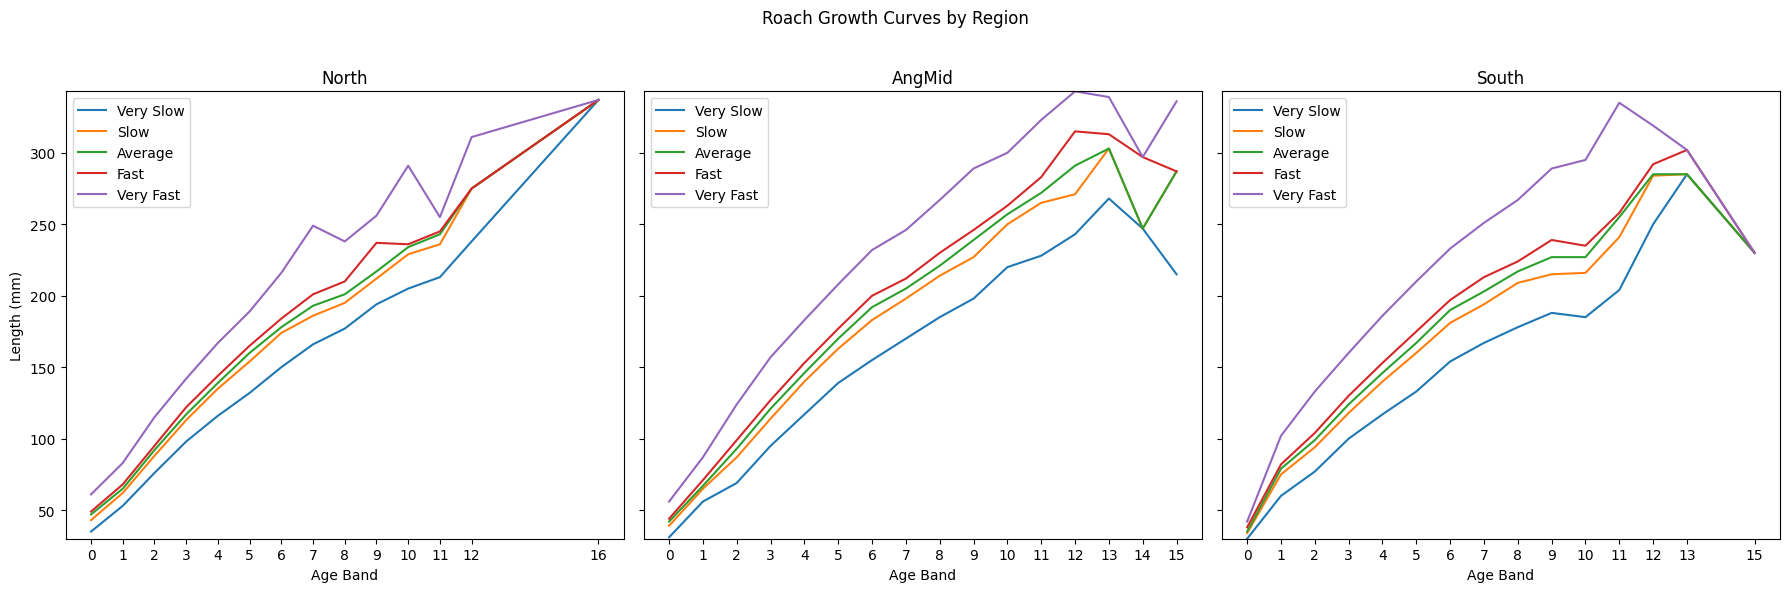

In [46]:
import seaborn as sns

import matplotlib.pyplot as plt

# Filter for Roach
roach_df = growth_curves_3region_pd[growth_curves_3region_pd['SPECIES_NAME'] == 'Roach'].copy()
roach_df['AGE_BAND'] = roach_df['AGE_BAND'].astype(int)

# Set up the plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
regions = ['North', 'AngMid', 'South']
ymin = roach_df[['very_slow', 'very_fast']].min().min()
ymax = roach_df[['very_slow', 'very_fast']].max().max()

for ax, region in zip(axes, regions):
    region_df = roach_df[roach_df['region_group'] == region]
    if not region_df.empty:
        sns.lineplot(data=region_df, x='AGE_BAND', y='very_slow', label='Very Slow', ax=ax)
        sns.lineplot(data=region_df, x='AGE_BAND', y='slow', label='Slow', ax=ax)
        sns.lineplot(data=region_df, x='AGE_BAND', y='average', label='Average', ax=ax)
        sns.lineplot(data=region_df, x='AGE_BAND', y='fast', label='Fast', ax=ax)
        sns.lineplot(data=region_df, x='AGE_BAND', y='very_fast', label='Very Fast', ax=ax)
    ax.set_title(region)
    ax.set_xlabel('Age Band')
    ax.set_ylabel('Length (mm)')
    ax.set_ylim(ymin, ymax)
    ax.set_xticks(sorted(region_df['AGE_BAND'].unique()))


axes[0].legend(loc='upper left')
plt.suptitle('Roach Growth Curves by Region')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [47]:
from pyspark.sql.functions import expr, when, col

# Map REGION to new region groups
df_2region = df_with_region.withColumn(
    "region_group",
    when(col("REGION").isin("Yorkshire and North East", "North West"), "North")
    .when(col("REGION").isin("South West", "South East", "Anglian", "Midlands"), "South")
    .otherwise("Other")
)

# Check for any "Other" values and raise a warning if present
other_count = df_2region.filter(col("region_group") == "Other").count()
if other_count > 0:
    print(f"WARNING: {other_count} records found with region_group='Other'. Please check REGION values.")

# For each species, age, and region_group, compute the quantiles of FISH_LENGTH
growth_curves_2region = (
    df_2region.groupBy("SPECIES_NAME", "AGE_BAND", "region_group")
      .agg(
          expr("percentile_approx(FISH_LENGTH, 0.1) as very_slow"),
          expr("percentile_approx(FISH_LENGTH, 0.4) as slow"),
          expr("percentile_approx(FISH_LENGTH, 0.5) as average"),
          expr("percentile_approx(FISH_LENGTH, 0.6) as fast"),
          expr("percentile_approx(FISH_LENGTH, 0.9) as very_fast"),
          expr("count(FISH_LENGTH) as n")
      )
      .orderBy("SPECIES_NAME", expr("cast(AGE_BAND as int)"), "region_group")
)

growth_curves_2region.show(100, truncate=False)

+------------+--------+------------+---------+----+-------+----+---------+-----+
|SPECIES_NAME|AGE_BAND|region_group|very_slow|slow|average|fast|very_fast|n    |
+------------+--------+------------+---------+----+-------+----+---------+-----+
|Barbel      |0       |North       |66       |66  |66     |66  |66       |10   |
|Barbel      |0       |South       |30       |36  |38     |44  |105      |160  |
|Barbel      |1       |North       |62       |82  |93     |95  |113      |466  |
|Barbel      |1       |South       |82       |102 |105    |110 |130      |1187 |
|Barbel      |2       |North       |114      |129 |133    |138 |181      |817  |
|Barbel      |2       |South       |112      |157 |165    |171 |210      |1606 |
|Barbel      |3       |North       |158      |179 |182    |190 |241      |657  |
|Barbel      |3       |South       |164      |222 |229    |235 |277      |855  |
|Barbel      |4       |North       |217      |257 |268    |297 |360      |343  |
|Barbel      |4       |South

In [48]:
import pandas as pd

# Collect the growth_curves_region DataFrame to a Pandas DataFrame
growth_curves_2region_pd = growth_curves_2region.toPandas()

# Create a Pandas Excel writer using XlsxWriter as the engine
with pd.ExcelWriter("outputs/growth_curves_2region_by_species.xlsx", engine="xlsxwriter") as writer:
    # Write the full DataFrame to a sheet
    growth_curves_2region_pd.to_excel(writer, sheet_name="All_Data", index=False)
    # Write one sheet per species
    for species, group in growth_curves_2region_pd.groupby("SPECIES_NAME"):
        group.to_excel(writer, sheet_name=species[:31], index=False)

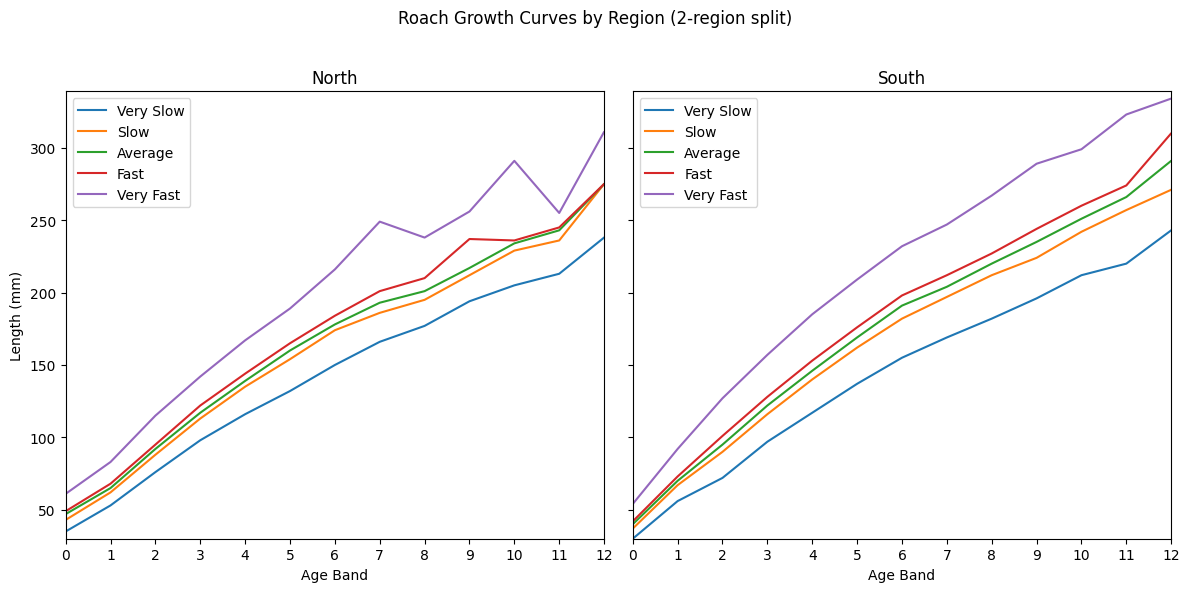

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for Roach in the 2-region DataFrame
roach_df_2region = growth_curves_2region_pd[growth_curves_2region_pd['SPECIES_NAME'] == 'Roach'].copy()
roach_df_2region['AGE_BAND'] = roach_df_2region['AGE_BAND'].astype(int)

# Set up the plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
regions = ['North', 'South']
ymin = roach_df_2region[['very_slow', 'very_fast']].min().min()
ymax = roach_df_2region[['very_slow', 'very_fast']].max().max()

for ax, region in zip(axes, regions):
    region_df = roach_df_2region[roach_df_2region['region_group'] == region]
    if not region_df.empty:
        sns.lineplot(data=region_df, x='AGE_BAND', y='very_slow', label='Very Slow', ax=ax)
        sns.lineplot(data=region_df, x='AGE_BAND', y='slow', label='Slow', ax=ax)
        sns.lineplot(data=region_df, x='AGE_BAND', y='average', label='Average', ax=ax)
        sns.lineplot(data=region_df, x='AGE_BAND', y='fast', label='Fast', ax=ax)
        sns.lineplot(data=region_df, x='AGE_BAND', y='very_fast', label='Very Fast', ax=ax)
    ax.set_title(region)
    ax.set_xlabel('Age Band')
    ax.set_ylabel('Length (mm)')
    ax.set_ylim(ymin, ymax)
    ax.set_xticks(sorted(region_df['AGE_BAND'].unique()))
    ax.set_xlim(left=0, right=12)

axes[0].legend(loc='upper left')
plt.suptitle('Roach Growth Curves by Region (2-region split)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


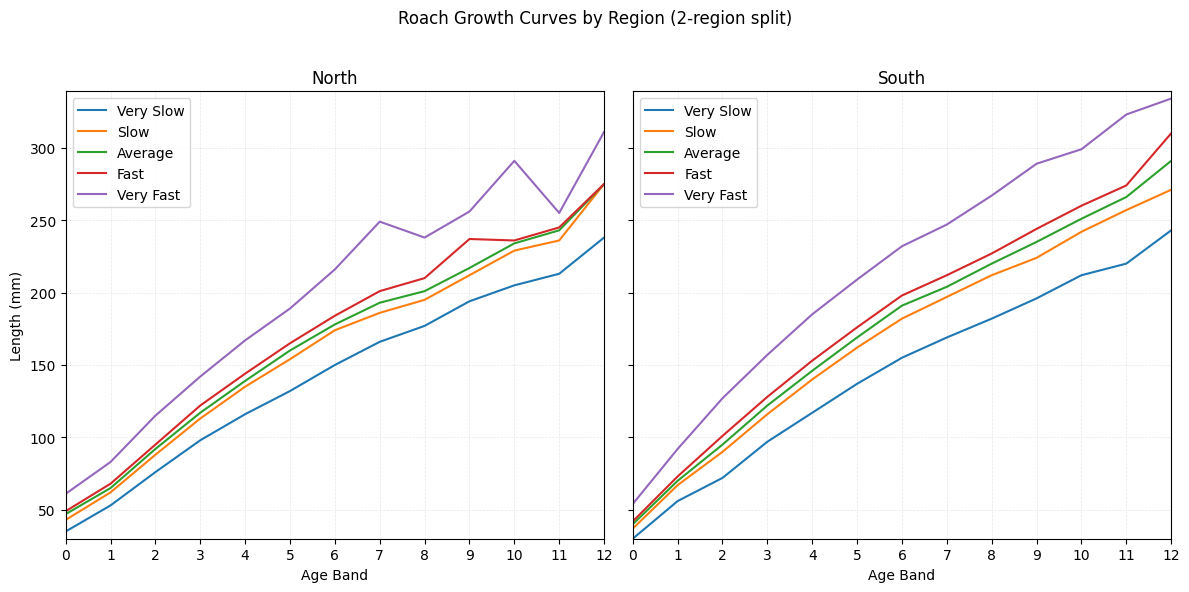

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for Roach in the 2-region DataFrame
roach_df_2region = growth_curves_2region_pd[growth_curves_2region_pd['SPECIES_NAME'] == 'Roach'].copy()
roach_df_2region['AGE_BAND'] = roach_df_2region['AGE_BAND'].astype(int)

# Set up the plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
regions = ['North', 'South']
ymin = roach_df_2region[['very_slow', 'very_fast']].min().min()
ymax = roach_df_2region[['very_slow', 'very_fast']].max().max()

for ax, region in zip(axes, regions):
    region_df = roach_df_2region[roach_df_2region['region_group'] == region]
    if not region_df.empty:
        sns.lineplot(data=region_df, x='AGE_BAND', y='very_slow', label='Very Slow', ax=ax)
        sns.lineplot(data=region_df, x='AGE_BAND', y='slow', label='Slow', ax=ax)
        sns.lineplot(data=region_df, x='AGE_BAND', y='average', label='Average', ax=ax)
        sns.lineplot(data=region_df, x='AGE_BAND', y='fast', label='Fast', ax=ax)
        sns.lineplot(data=region_df, x='AGE_BAND', y='very_fast', label='Very Fast', ax=ax)
    ax.set_title(region)
    ax.set_xlabel('Age Band')
    ax.set_ylabel('Length (mm)')
    ax.set_ylim(ymin, ymax)
    ax.set_xticks(sorted(region_df['AGE_BAND'].unique()))
    ax.set_xlim(left=0, right=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.3)

axes[0].legend(loc='upper left')
plt.suptitle('Roach Growth Curves by Region (2-region split)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


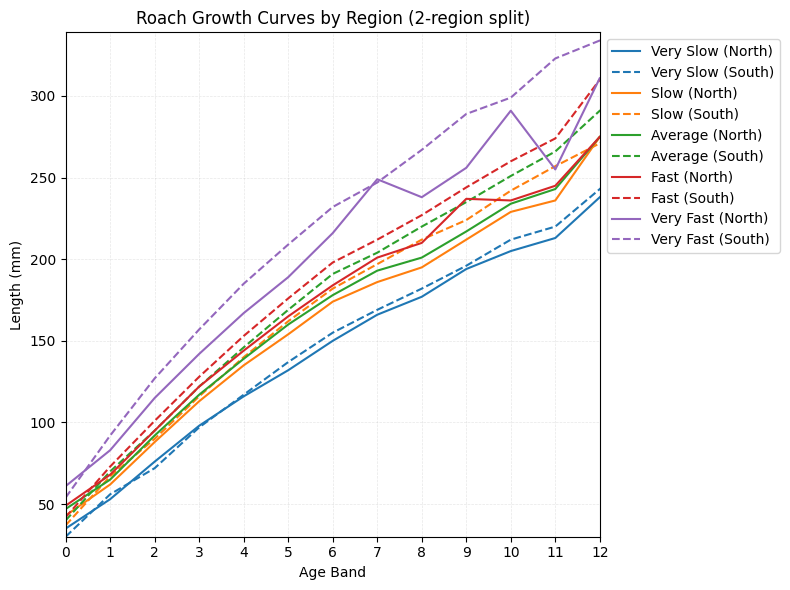

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for Roach in the 2-region DataFrame
roach_df_2region = growth_curves_2region_pd[growth_curves_2region_pd['SPECIES_NAME'] == 'Roach'].copy()
roach_df_2region['AGE_BAND'] = roach_df_2region['AGE_BAND'].astype(int)

fig, ax = plt.subplots(figsize=(8, 6))
regions = ['North', 'South']
ymin = roach_df_2region[['very_slow', 'very_fast']].min().min()
ymax = roach_df_2region[['very_slow', 'very_fast']].max().max()

# Define line styles for each region
region_linestyles = {
    'North': 'solid',
    'South': 'dashed'
}

# Define quantiles and assign colors
quantiles = ['very_slow', 'slow', 'average', 'fast', 'very_fast']
palette = sns.color_palette(n_colors=len(quantiles))
quantile_colors = dict(zip(quantiles, palette))

for quantile in quantiles:
    for region in regions:
        region_df = roach_df_2region[roach_df_2region['region_group'] == region]
        if not region_df.empty:
            sns.lineplot(
                data=region_df,
                x='AGE_BAND',
                y=quantile,
                label=f'{quantile.replace("_", " ").title()} ({region})',
                ax=ax,
                color=quantile_colors[quantile],
                linestyle=region_linestyles[region]
            )

ax.set_title('Roach Growth Curves by Region (2-region split)')
ax.set_xlabel('Age Band')
ax.set_ylabel('Length (mm)')
ax.set_ylim(ymin, ymax)
ax.set_xticks(sorted(roach_df_2region['AGE_BAND'].unique()))
ax.set_xlim(left=0, right=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.3)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


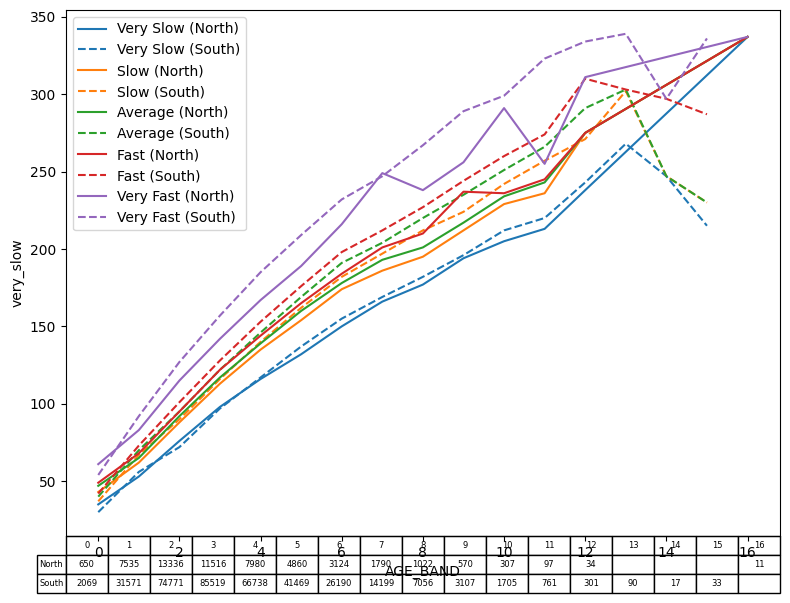

<Figure size 640x480 with 0 Axes>

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for Roach in the 2-region DataFrame
roach_df_2region = growth_curves_2region_pd[growth_curves_2region_pd['SPECIES_NAME'] == 'Roach'].copy()
roach_df_2region['AGE_BAND'] = roach_df_2region['AGE_BAND'].astype(int)

fig, ax = plt.subplots(figsize=(8, 6))
regions = ['North', 'South']
ymin = roach_df_2region[['very_slow', 'very_fast']].min().min()
ymax = roach_df_2region[['very_slow', 'very_fast']].max().max()

# Define line styles for each region
region_linestyles = {
    'North': 'solid',
    'South': 'dashed'
}

# Define quantiles and assign colors
quantiles = ['very_slow', 'slow', 'average', 'fast', 'very_fast']
palette = sns.color_palette(n_colors=len(quantiles))
quantile_colors = dict(zip(quantiles, palette))

for quantile in quantiles:
    for region in regions:
        region_df = roach_df_2region[roach_df_2region['region_group'] == region]
        if not region_df.empty:
            sns.lineplot(
                data=region_df,
                x='AGE_BAND',
                y=quantile,
                label=f'{quantile.replace("_", " ").title()} ({region})',
                ax=ax,
                color=quantile_colors[quantile],
                linestyle=region_linestyles[region]
            )

age_bands = sorted(roach_df_2region['AGE_BAND'].unique())
table_data = []
for region in regions:
    n_counts = []
    for age in age_bands:
        match = roach_df_2region[(roach_df_2region['region_group'] == region) & (roach_df_2region['AGE_BAND'] == age)]
        if not match.empty:
            n_counts.append(int(match['n'].iloc[0]))
        else:
            n_counts.append("")
    table_data.append(n_counts)

# Add the table below the plot
row_labels = regions
col_labels = [str(age) for age in age_bands]
the_table = ax.table(
    cellText=table_data,
    rowLabels=row_labels,
    colLabels=col_labels,
    loc='bottom',
    cellLoc='center'
)

# Adjust layout to make room for the table
plt.subplots_adjust(left=0.2, bottom=0.25)
plt.tight_layout()
plt.show()

ax.set_title('Roach Growth Curves by Region (2-region split)')
ax.set_xlabel('Age Band')
ax.set_ylabel('Length (mm)')
ax.set_ylim(ymin, ymax)
ax.set_xticks(sorted(roach_df_2region['AGE_BAND'].unique()))
ax.set_xlim(left=0, right=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.3)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()
